**COMP263_GROUP5_PROJECT _BRAIN_TUMOR_DETECTION. TEAM : Juan Arevalo, Ruben Ormeno, Samantha Ortiz de Foronda, Mariela Ramos Vila, Jose Muniz**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
from tensorflow.keras.applications import VGG19, ResNet50
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from cv2 import imread
import warnings
warnings.filterwarnings("ignore")
from PIL import Image



In [55]:
# Constants
path = "../content/drive/MyDrive/brain_tumor_dataset/to_train_validate"
input_shape = (224, 224, 3)


In [58]:
# Data Augmentation
image_generator = ImageDataGenerator(
    rescale=1./255, # normilize
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.1 #for validation test
)

# Data Preparation
training_set = image_generator.flow_from_directory(
    batch_size=16,
    directory=path,
    shuffle=True,
    target_size=input_shape[:2],
    subset="training",
    color_mode='rgb',
    class_mode='binary'
)

testing_set = image_generator.flow_from_directory(
    batch_size=16,
    directory=path,
    shuffle=True,
    target_size=input_shape[:2],
    subset="validation",
    color_mode='rgb',
    class_mode='binary'
)



Found 218 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


Tumour MRI Image

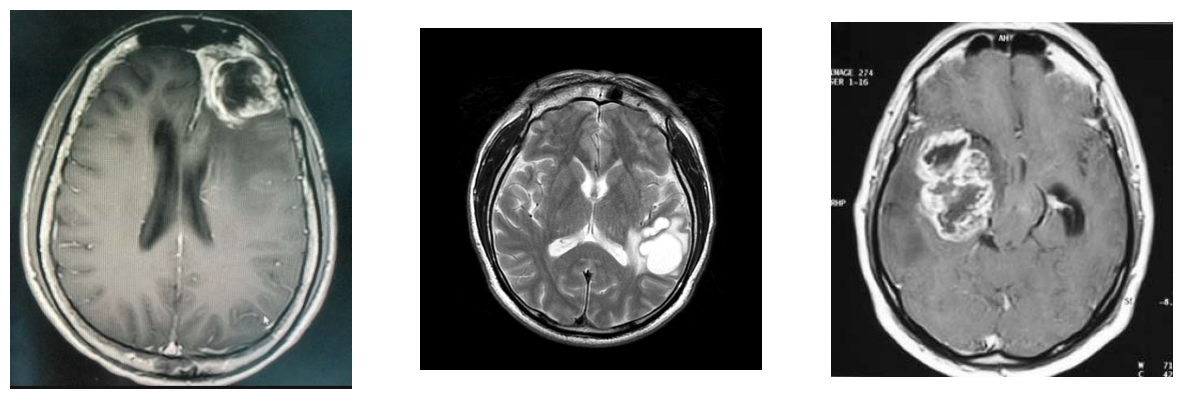

In [44]:
# Tumor MRI
#Selecting 3 images.
yes_dir = os.path.join(path, "yes")
yes_images = os.listdir(yes_dir)
img_paths = [os.path.join(yes_dir, yes_images[i]) for i in range(3)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img_path in zip(axes, img_paths):
    img = imread(img_path)

    ax.imshow(img)
    ax.axis('off') # Hide axes ticks
plt.show()

Normal MRI Image

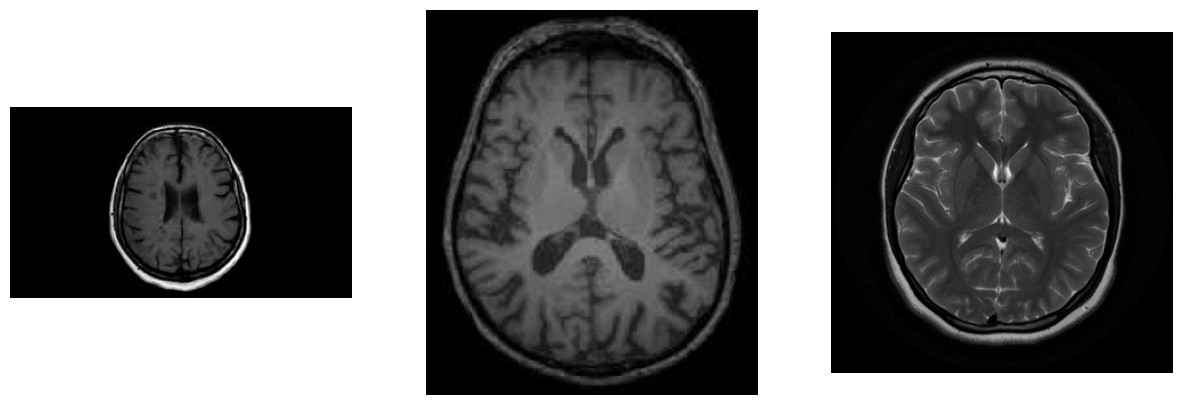

In [45]:
#normal image
no_dir = os.path.join(path, "no")
no_images = os.listdir(no_dir)

#Selecting 3 images.
img_paths = [os.path.join(no_dir, no_images[i]) for i in range(3)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img_path in zip(axes, img_paths):
    img = imread(img_path)
    ax.imshow(img)
    ax.axis('off') # Hide axes ticks
plt.show()

In [46]:
# Function to build model

def build_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dropout(0.4)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(base_model.input, x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])
    return model


In [69]:
def predict_from_directory(model, directory_path, image_size=(224, 224)):
    """
    Predicts images in a specified directory using a trained model.

    Parameters:
    - model: The trained model for predictions.
    - directory_path: Path to the directory containing images for prediction.
    - image_size: A tuple specifying the size to which images will be resized.
    """

    images, predictions, filenames = [], [], []
    #processed_images
    # Iterate through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory_path, filename)
            img = Image.open(img_path).resize(image_size)

            # Convert the image to a numpy array and preprocess for the model
            img_array = np.expand_dims(np.array(img), axis=0)  # Add batch dimension

            # Store image data and filename for later use
            images.append(img)
            filenames.append(filename)

            # Prediction
            prediction = model.predict(img_array)
            predicted_class = 'Tumor' if prediction[0][0] < 0.5 else 'Not a Tumor'
            predictions.append(predicted_class)

    # Plotting the image and the prediction
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f'{filenames[i]}\nPredicted: {predictions[i]}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots
    plt.tight_layout()
    plt.show()


In [47]:
import numpy as np

def plot_predictions(model, generator, title='Model Predictions'):
    """
    Plot images and their predicted labels using a trained model.

    Parameters:
        model (tf.keras.Model): The trained model for predictions.
        generator (tf.keras.preprocessing.image.DirectoryIterator): Image data generator.
        title (str): Title for the plots.
    """
    # Get a batch of images from the generator
    x, y = next(generator)
    predictions = model.predict(x)
    predicted_classes = (predictions > 0.5).astype(int)

    plt.figure(figsize=(12, 12))
    for i in range(9):  # Plot the first 9 images and predictions
        img_index = generator.batch_index - 1 + i  # Adjusted for the current batch
        # Ensure img_index does not exceed the total number of images
        if img_index < len(generator.filenames):
            # Fetching the filename for the current image
            filename = generator.filenames[img_index].split('/')[-1]  # Extract filename
            plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            # Update title to include filename
            plt.title(f'File: {filename}\nActual: {y[i]}\nPredicted: {predicted_classes[i][0]}', fontsize=10)
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

#### Train VGG19 model


In [48]:
# VGG19 Model
vgg19_model = build_model(VGG19(input_shape=input_shape, include_top=False, weights='imagenet'))
vgg19_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
vgg19_history = vgg19_model.fit(training_set, validation_data=testing_set, callbacks=[early_stopping],epochs=60)



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

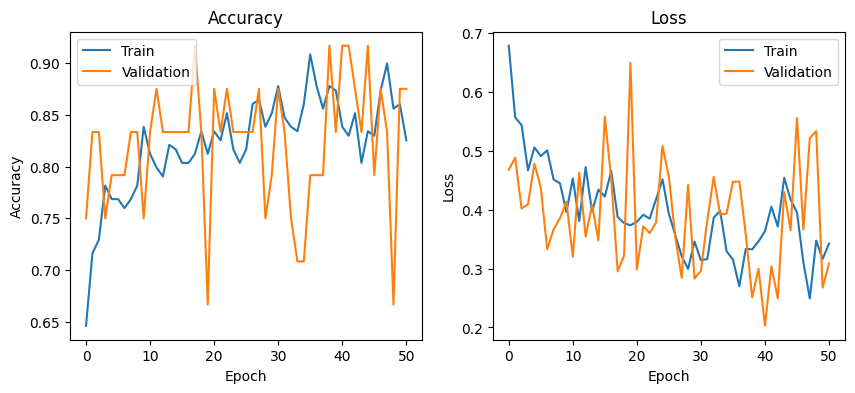

In [71]:
# Visualization of training results
# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg19_history.history['accuracy'], label='Train')
plt.plot(vgg19_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(vgg19_history.history['loss'], label='Train')
plt.plot(vgg19_history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing

In [72]:
test_loss, test_accuracy = vgg19_model.evaluate(testing_set, verbose=2)


2/2 - 3s - loss: 0.3307 - accuracy: 0.9130 - 3s/epoch - 1s/step


PREDICTION USING VGG19

1/1 [==============================] - 0s 18ms/step


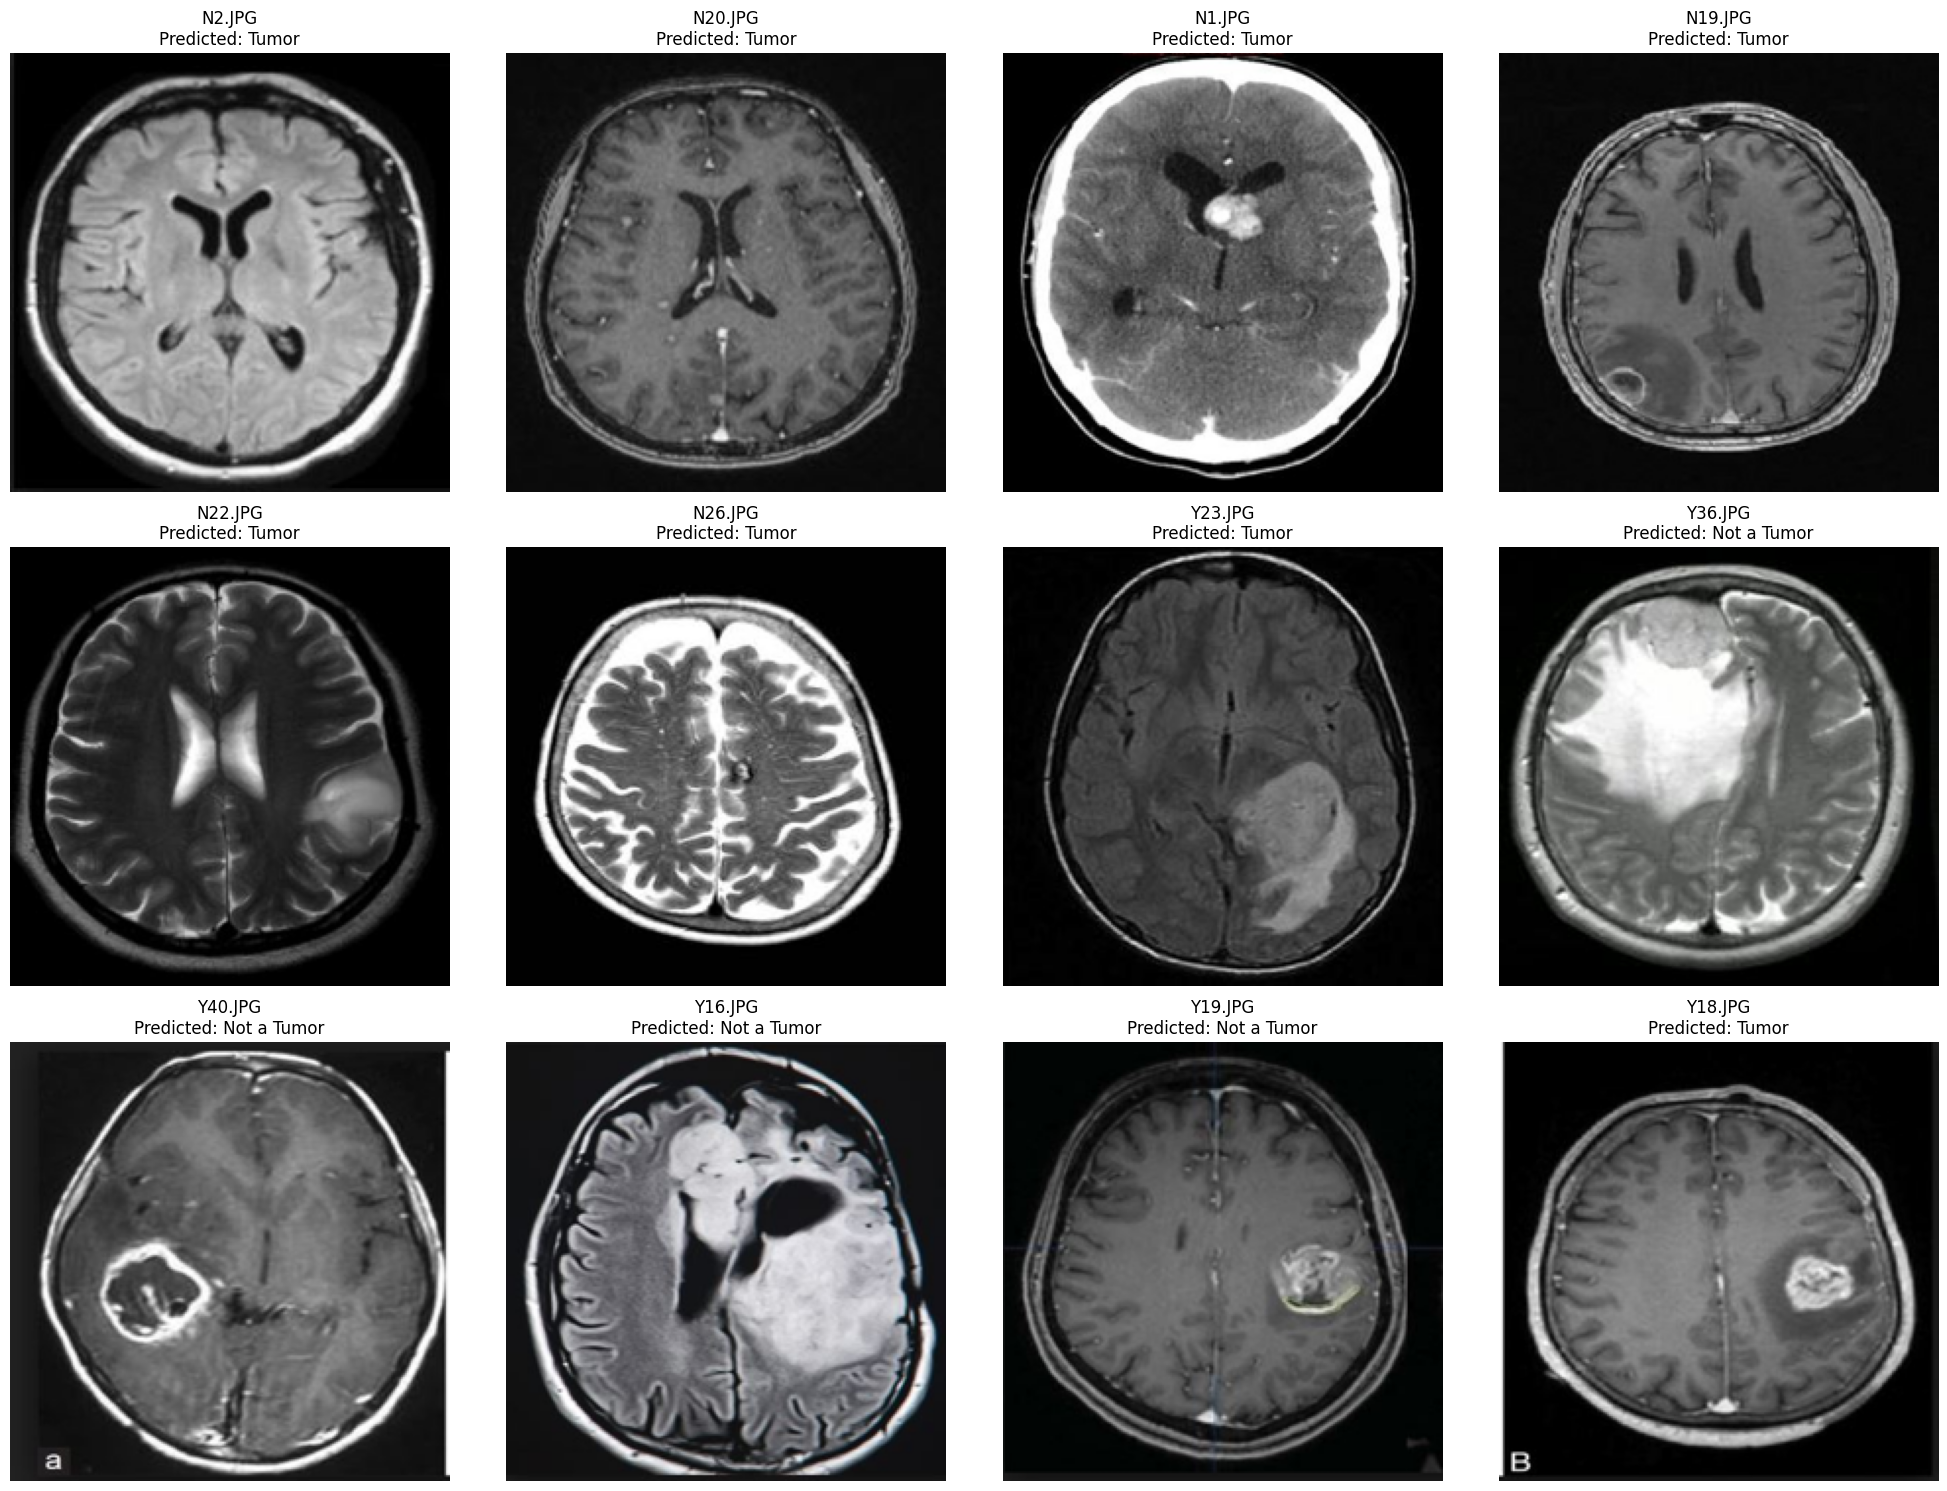

In [70]:
predict_from_directory(vgg19_model, '../content/drive/MyDrive/brain_tumor_dataset/to_predict')

### **Train** ResNet50

In [59]:
# ResNet50 Model
resnet_model = build_model(ResNet50(input_shape=input_shape, include_top=False, weights='imagenet'))
resnet_model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [61]:
# Training the ResNet50 model
#resnet_history = resnet_model.fit(training_set,validation_data=testing_set,callbacks=[early_stopping], epochs=60)
resnet_history = resnet_model.fit(training_set,validation_data=testing_set, epochs=60)


Epoch 1/60
14/14 [==============================] - 4s 311ms/step - loss: 0.8283 - accuracy: 0.6743 - val_loss: 0.6163 - val_accuracy: 0.6522
Epoch 2/60
14/14 [==============================] - 6s 402ms/step - loss: 0.7109 - accuracy: 0.7018 - val_loss: 0.4460 - val_accuracy: 0.7391
Epoch 3/60
14/14 [==============================] - 4s 302ms/step - loss: 0.7193 - accuracy: 0.7110 - val_loss: 0.7958 - val_accuracy: 0.7391
Epoch 4/60
14/14 [==============================] - 4s 282ms/step - loss: 0.7586 - accuracy: 0.7110 - val_loss: 0.7839 - val_accuracy: 0.6087
Epoch 5/60
14/14 [==============================] - 5s 383ms/step - loss: 0.8147 - accuracy: 0.6284 - val_loss: 0.7192 - val_accuracy: 0.7391
Epoch 6/60
14/14 [==============================] - 4s 283ms/step - loss: 0.6888 - accuracy: 0.6789 - val_loss: 0.7424 - val_accuracy: 0.7391
Epoch 7/60
14/14 [==============================] - 4s 311ms/step - loss: 0.8617 - accuracy: 0.6743 - val_loss: 0.4922 - val_accuracy: 0.7826
Epoch 

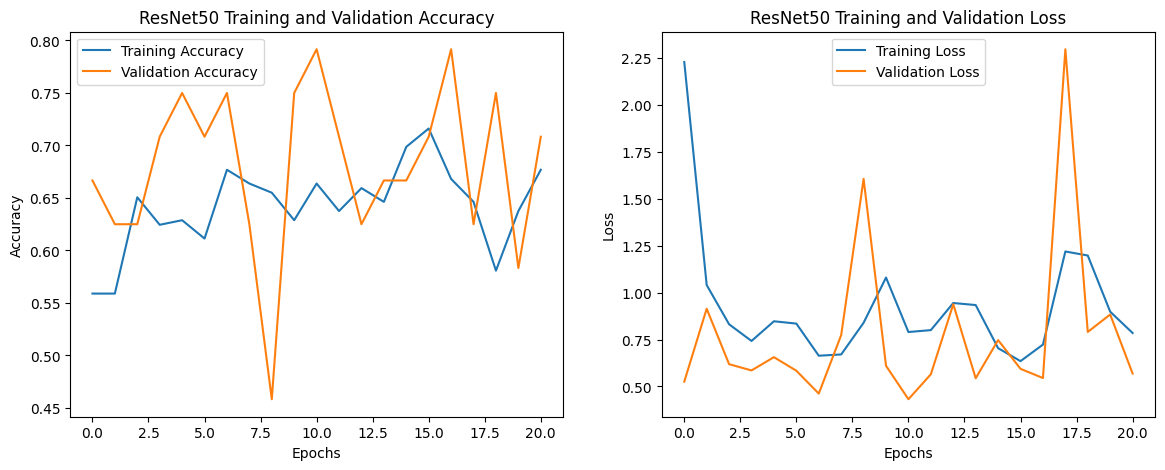

In [53]:
#Plotting Training and Validation Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
test_loss, test_accuracy = resnet_model.evaluate(testing_set, verbose=2)


2/2 - 1s - loss: 0.5746 - accuracy: 0.7826 - 906ms/epoch - 453ms/step


Validating Predictions


PREDICTION USING RESNET

1/1 [==============================] - 0s 20ms/step


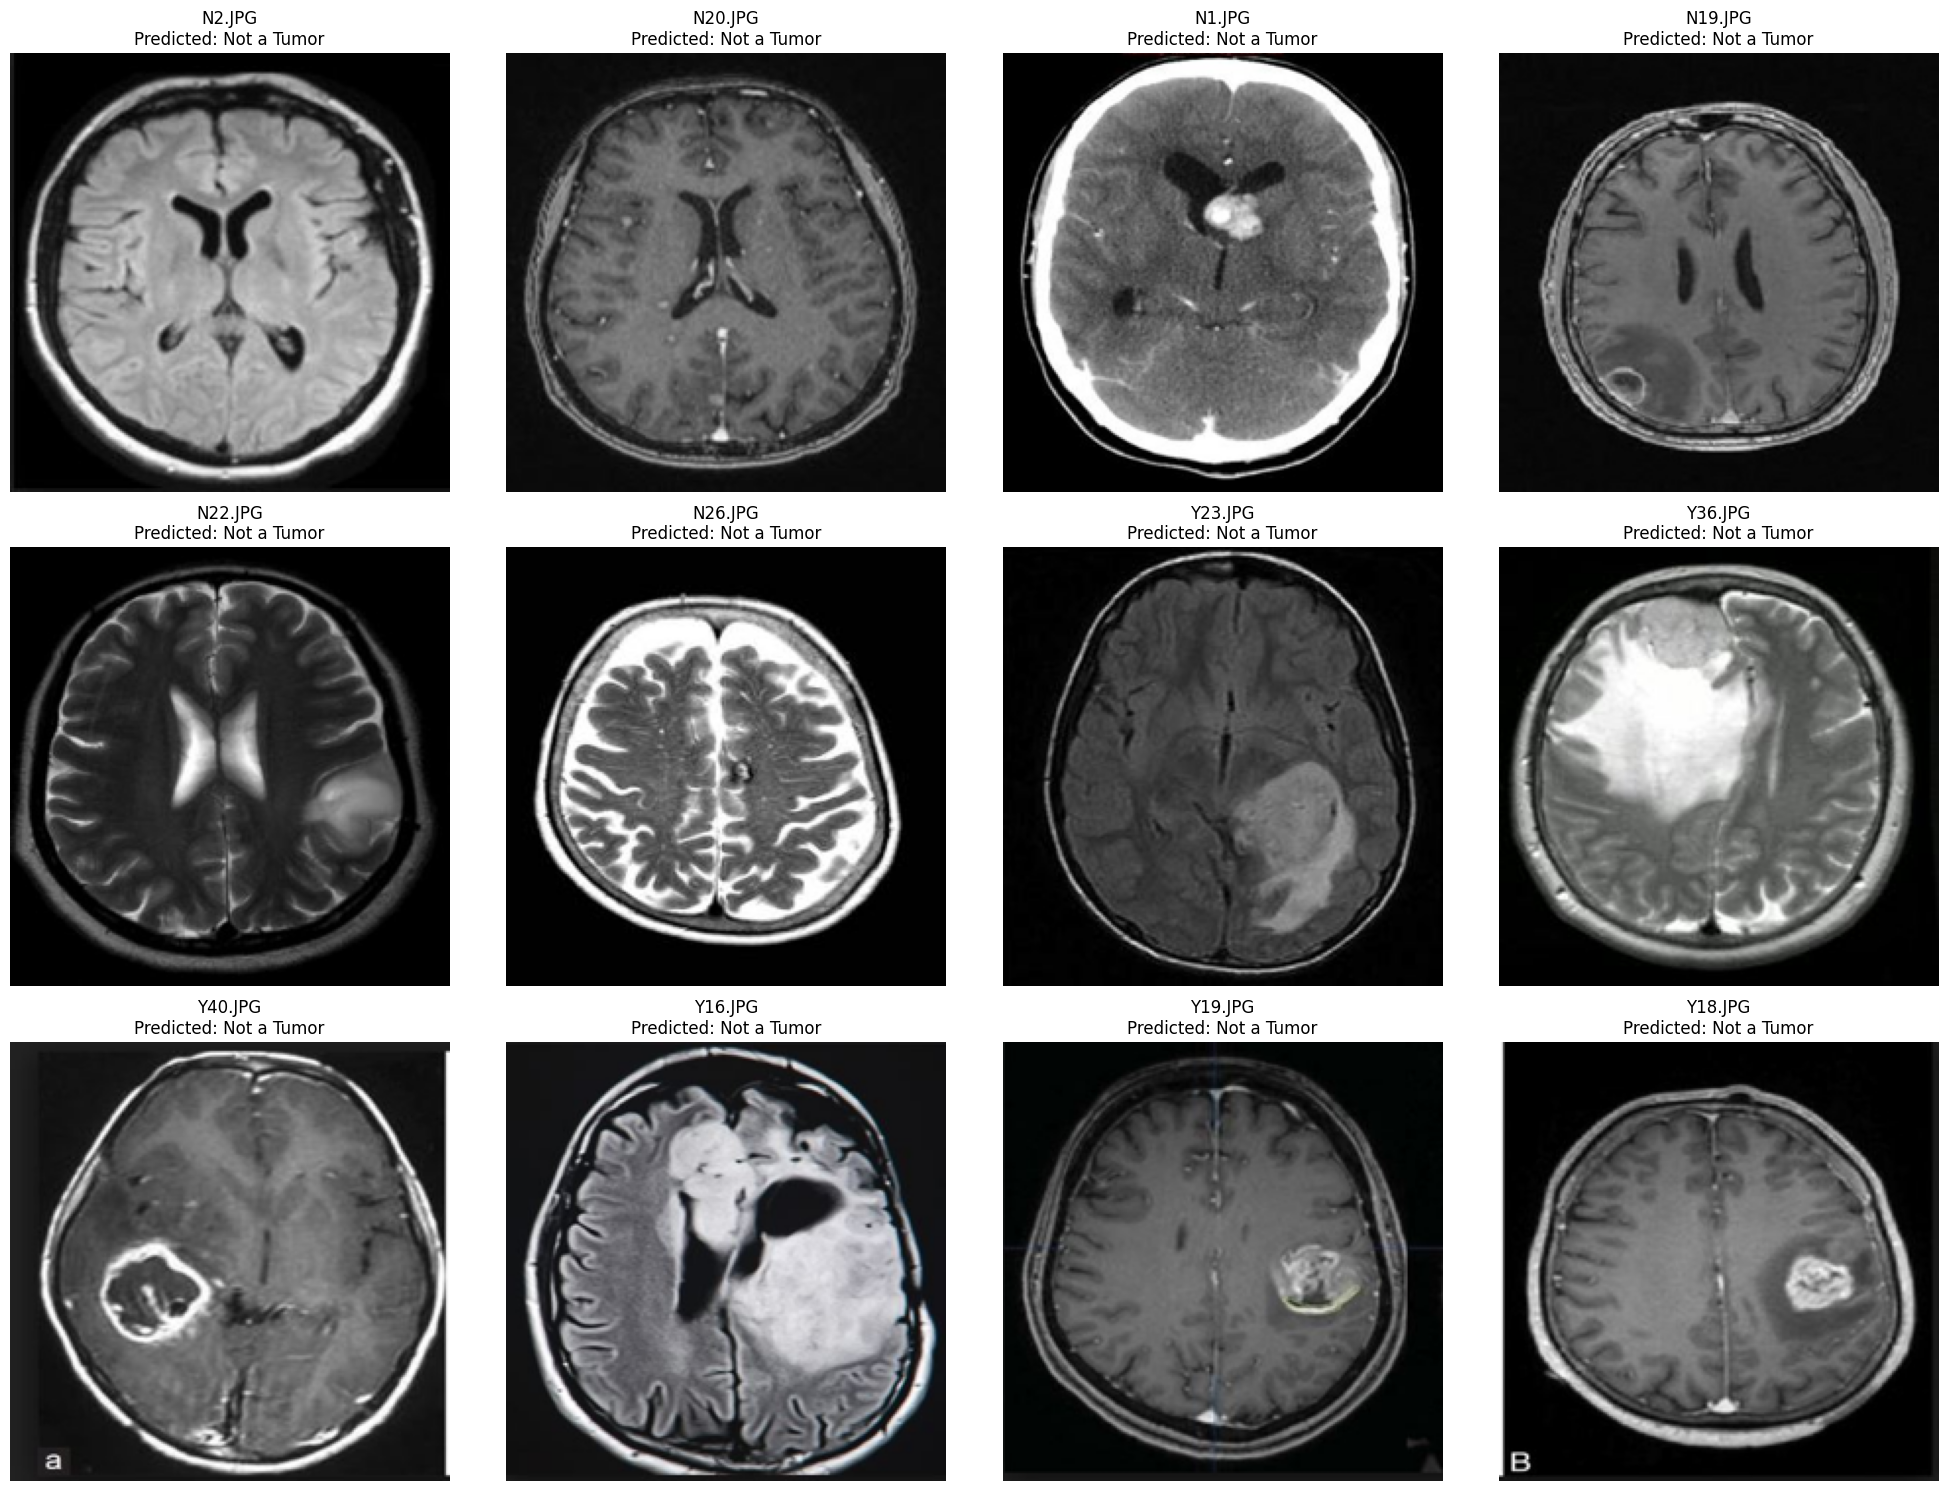

In [75]:
predict_from_directory(resnet_model, '../content/drive/MyDrive/brain_tumor_dataset/to_predict')